# example-single-particle.ipynb

This notebook performs a partial segmentation workflow adapted for compressed F50 sand experiments and allows for a preview of an STL mesh to be created and viewed in the notebook, including smoothing and simplifying postprocessing steps.

Note: this notebook takes inputs from a YAML file like [segmentflow-input.yml](segmentflow-input.yml). Try running with the example settings in that file (after changing the path to the CT images) or leave fields blank to use default values.

## Import packages

In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import open3d as o3d
from pathlib import Path
import pandas as pd
import segment
from scipy import ndimage as ndi
from skimage import (
        color, feature, filters, morphology, measure, segmentation, util)
from stl import mesh
import sys
import yaml
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load, preprocess, binarize, and segment images

Value for "Segmentation Plot Number of Images" not provided. Setting to default value: 3
Loading images...
--> Images loaded as 3D array:  (100, 150, 150)
Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [5, 95]...
--> Preprocessing complete
Binarizing images...
--> Calculating Otsu threshold(s)...
--> Binarization complete.
Segmenting images...
--> Number of particle(s) before border exclusion:  374
--> Excluding border particles...
--> Segmentation complete. 139 particle(s) segmented.
Plotting images: [25, 50, 75]


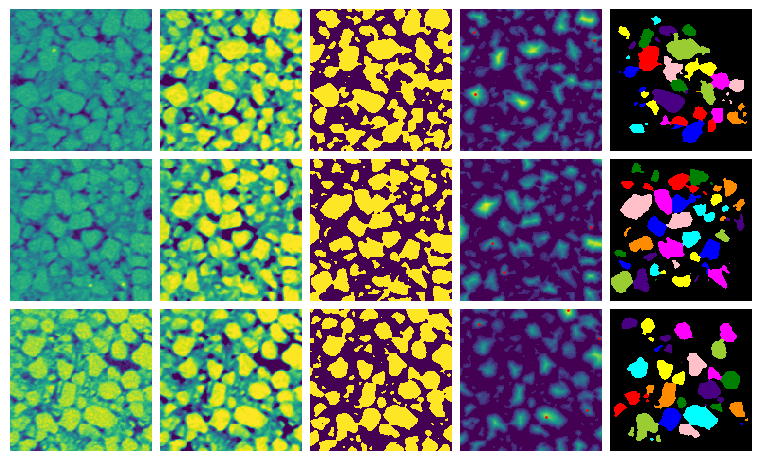

In [2]:
# Load YAML inputs into ui dictionary
yaml_path = Path('segmentflow-input.yml')
ui = segment.load_inputs(yaml_path)
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
        ui['ct_img_dir'],
        slice_crop=ui['slice_crop'],
        row_crop=[450, 600], 
        col_crop=[100, 250],
        file_suffix=ui['file_suffix'])
# Preprocess images
imgs_pre = segment.preprocess(
        imgs, 
        median_filter=ui['pre_seg_med_filter'], 
        rescale_intensity_range=ui['rescale_range'])
# Binarize images
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
        imgs_pre, n_otsu_classes=ui['n_otsu_classes'], 
        n_selected_thresholds=ui['n_selected_classes'])
# Segment images
segment_dict = segment.watershed_segment(
        imgs_binarized, 
        min_peak_distance=ui['min_peak_dist'], 
        use_int_dist_map=ui['use_int_dist_map'], 
        exclude_borders=ui['exclude_borders'], 
        return_dict=True)
# Plot segmentation results
fig, axes = segment.plot_segment_steps(
        imgs, imgs_pre, imgs_binarized, segment_dict, 
        slices=ui['seg_fig_slices'])
plt.show()

## Plot particle labels

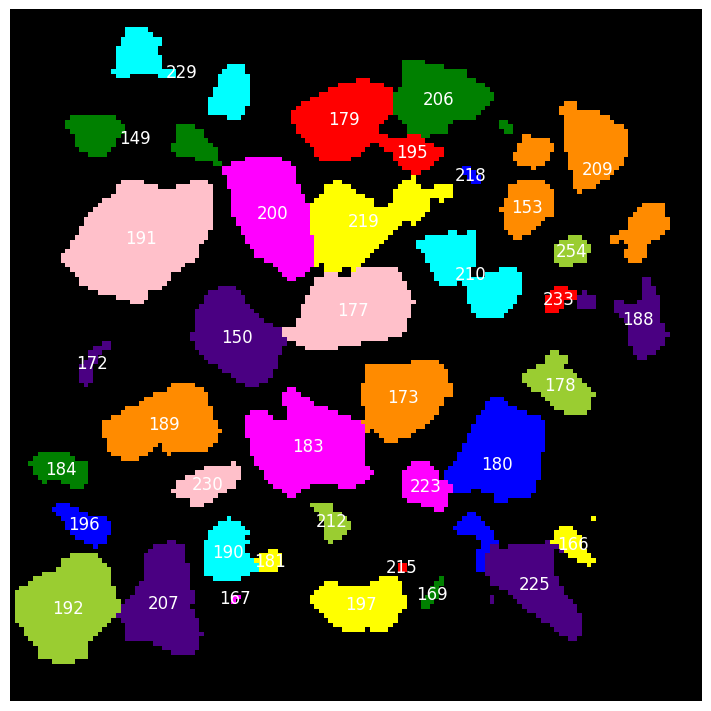

In [3]:
fig, ax = segment.plot_particle_labels(segment_dict, 50)
plt.show()

## Isolate particle and plot slices

Plotting images: {37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62}


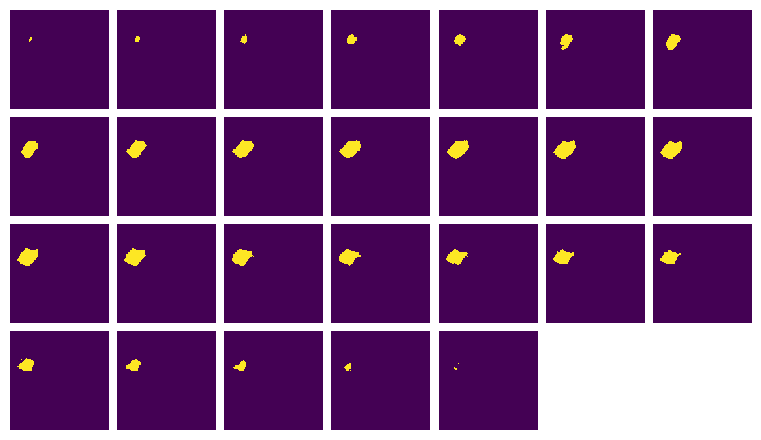

In [4]:
particleID = 191
imgs_single_particle = segment.isolate_particle(segment_dict, particleID)
nonzero_slices = set(np.where(imgs_single_particle)[0])
fig, axes = segment.plot_imgs(
        imgs_single_particle, slices=nonzero_slices, imgs_per_row=7)
plt.show()

## Create surface mesh and plot

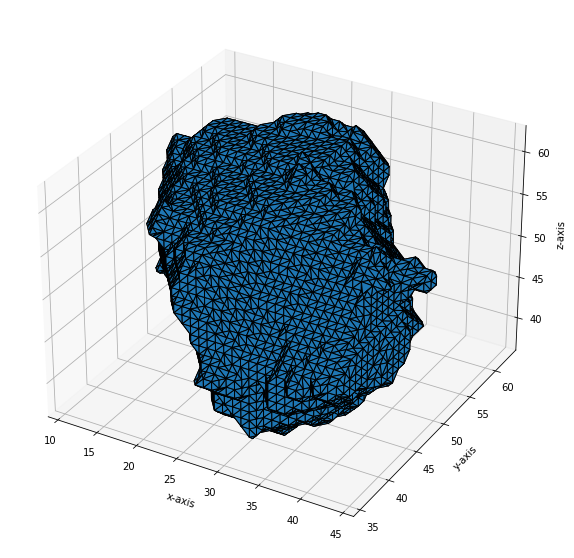

In [5]:
# Create surface mesh with voxel_step_size = 1
stl_mesh, verts, faces, normals, values = segment.create_surface_mesh(
        imgs_single_particle, slice_crop=ui['slice_crop'], 
        row_crop=ui['row_crop'], col_crop=ui['col_crop'], 
        spatial_res=ui['spatial_res'], voxel_step_size=1)
# Plot surface mesh
fig, ax = segment.plot_mesh_3D(verts, faces)
plt.show()

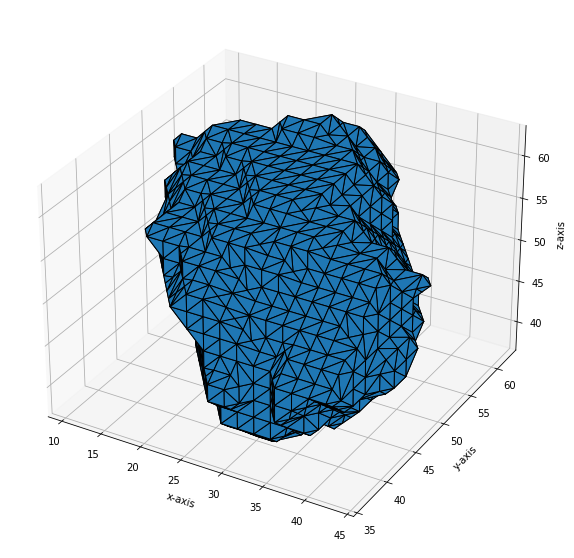

In [11]:
# Set save path for surface mesh
mesh_save_path = (
        Path(ui['stl_dir_location']) 
        / f'{particleID}_marching-cubes.stl')
# Create surface mesh with voxel_step_size = 1
verts, faces, normals, values = segment.create_surface_mesh(
        imgs_single_particle, slice_crop=ui['slice_crop'], 
        row_crop=ui['row_crop'], col_crop=ui['col_crop'], 
        spatial_res=ui['spatial_res'], voxel_step_size=2,
        save_path=str(mesh_save_path))
# Plot surface mesh
fig, ax = segment.plot_mesh_3D(verts, faces)
plt.show()

STL saved: example-output\191_smoothed.stl


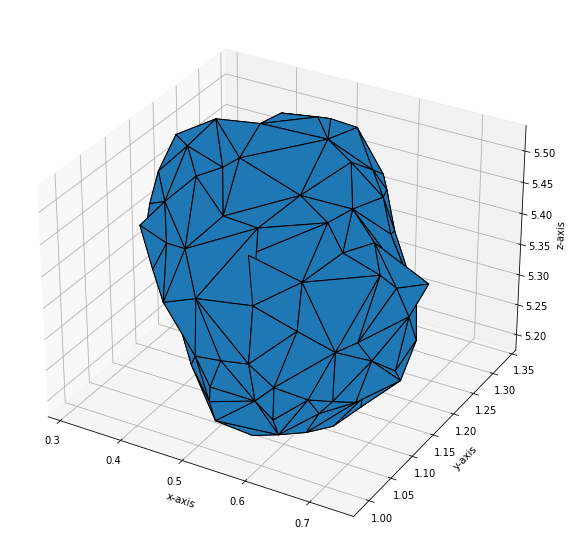

In [17]:
# Smooth mesh
smoothed_mesh, smoothed_props = segment.postprocess_mesh(
        mesh_save_path, smooth_iter=1)
# Save smoothed mesh
smoothed_save_path = (
        Path(ui['stl_dir_location']) 
        / f'{particleID}_smoothed.stl')
segment.save_stl(smoothed_save_path, smoothed_mesh)
# Plot smoothed mesh
fig, ax = segment.plot_stl(smoothed_save_path)
plt.show()

STL saved: example-output\191_simplified-to-100.stl


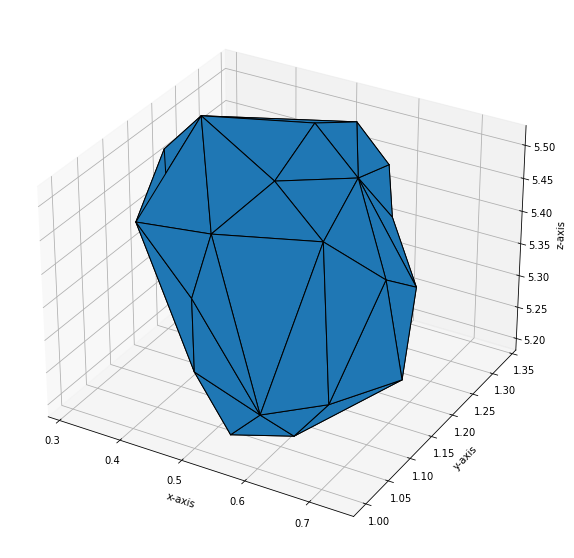

In [19]:
# Simplify mesh to target number of triangles
target_n_tris = 100
simplified_mesh, simplified_props = segment.postprocess_mesh(
        mesh_save_path, simplify_n_tris=target_n_tris, 
        iterative_simplify_factor=2)
# Save simplified mesh
simplified_save_path = (
        Path(ui['stl_dir_location']) 
        / f'{particleID}_simplified-to-{target_n_tris}.stl')
segment.save_stl(simplified_save_path, simplified_mesh)
# Plot simplified mesh
fig, ax = segment.plot_stl(simplified_save_path)
plt.show()